## Importing libraries

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import imageio

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Build data loading functions

In [3]:
# import gdown
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [131]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    print(cap)
    frames = []
    print(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
print(vocab)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']


In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),
                                           oov_token="",
                                           invert=True
                                          )

print(f"The vocabulary is : {char_to_num.get_vocabulary()}"
      f"(size ={char_to_num.vocabulary_size()} )")

The vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =40 )


In [7]:
char_to_num(['a', 'd', 'e', 'g'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 4, 5, 7], dtype=int64)>

In [8]:
num_to_char([1, 4, 5, 7])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'd', b'e', b'g'], dtype=object)>

In [9]:
def load_alignments(path:str) -> List[str]:
    print('fasd', path)
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'),(-1)))[1:]

In [107]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    print('path', path)
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    # alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    alignment_path = os.path.join('data', 'alignments', 's1', 'bbaf2n.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    # alignments = None
    return frames, alignments

In [128]:
path = ".\\data\\s1\\suspect-escapes-interrogation-room-while-wearing-ankle-shackles_AZjSGbbu.mpg"

In [129]:
tf.convert_to_tensor(path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'suspect-escapes-interrogation-room-while-wearing-ankle-shackles_AZjSGbbu'

In [132]:
frames, alignments = load_data(tf.convert_to_tensor(path))

path .\data\s1\suspect-escapes-interrogation-room-while-wearing-ankle-shackles_AZjSGbbu.mpg
< cv2.VideoCapture 0000021DD0C09910>
76.0
fasd data\alignments\s1\bbaf2n.align


In [14]:
frames[38]

<tf.Tensor: shape=(46, 140, 1), dtype=float32, numpy=
array([[[1.4991663 ],
        [1.4991663 ],
        [1.4991663 ],
        ...,
        [0.3373124 ],
        [0.29983324],
        [0.3373124 ]],

       [[1.4991663 ],
        [1.4991663 ],
        [1.4991663 ],
        ...,
        [0.3373124 ],
        [0.3373124 ],
        [0.3373124 ]],

       [[1.4616871 ],
        [1.4616871 ],
        [1.4242079 ],
        ...,
        [0.3373124 ],
        [0.3373124 ],
        [0.3373124 ]],

       ...,

       [[0.97445804],
        [0.97445804],
        [0.97445804],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.97445804],
        [0.97445804],
        [0.97445804],
        ...,
        [0.        ],
        [0.        ],
        [9.557184  ]],

       [[0.97445804],
        [0.97445804],
        [0.97445804],
        ...,
        [0.        ],
        [9.557184  ],
        [9.557184  ]]], dtype=float32)>

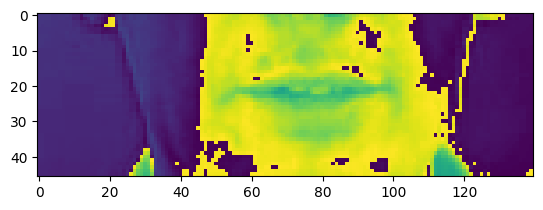

In [15]:
plt.imshow(frames[38])

In [16]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23], dtype=int64)>

In [17]:
tf.strings.reduce_join(([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]))

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [18]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Data Pipeline

In [19]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [20]:
frames, alignment = data.as_numpy_iterator().next()

path .\data\s1\srwi4p.mpg
fasd data\alignments\s1\srwi4p.align
path .\data\s1\lrbl1s.mpg
fasd data\alignments\s1\lrbl1s.align
path .\data\s1\bbil2n.mpg
fasd data\alignments\s1\bbil2n.align


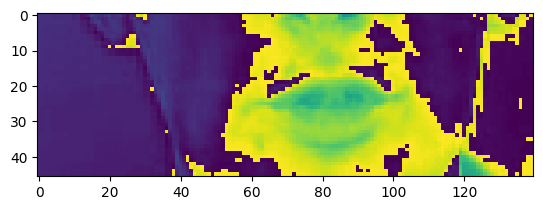

In [21]:
plt.imshow(frames[0][40])

In [22]:
alignment

array([[19,  5, 20, 39, 18,  5,  4, 39, 23,  9, 20,  8, 39,  9, 39,  6,
        15, 21, 18, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [12,  1, 25, 39, 18,  5,  4, 39,  2, 25, 39, 12, 39, 15, 14,  5,
        39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [23]:
sample = data.as_numpy_iterator()
val = sample.next()

path .\data\s1\swbv5a.mpg
fasd data\alignments\s1\swbv5a.align
path .\data\s1\pbwp6n.mpg
fasd data\alignments\s1\pbwp6n.align
path .\data\s1\lrwl5s.mpg


In [24]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 10.361949920654297]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.361949920654297]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.361949920654297]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.361949920654297]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.361949920654297]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.361949920654297]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.361949920654297]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

fasd data\alignments\s1\lrwl5s.align
path .\data\s1\srbh9s.mpg


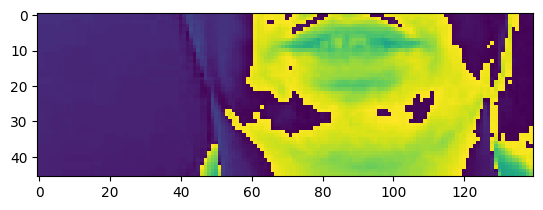

In [25]:
plt.imshow(val[0][1][40])

In [26]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white by v five again'>

## Design the Deep Neural Network

In [27]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [28]:
data.as_numpy_iterator().next()[0][0].shape

path .\data\s1\sbat7s.mpg
fasd data\alignments\s1\srbh9s.align
fasd data\alignments\s1\sbat7s.align
path .\data\s1\lrak8p.mpg
fasd data\alignments\s1\lrak8p.align
path .\data\s1\lwar7s.mpg
fasd data\alignments\s1\lwar7s.align


(75, 46, 140, 1)

In [122]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [59]:
y_hat = model.predict(val[0])
print(y_hat.shape)
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(y_hat[0])])

1/1 [==============================] - 1s 562ms/step
(2, 75, 41)


<tf.Tensor: shape=(), dtype=string, numpy=b'6nssju3ghsssssssgbswfsosssssssssssssl'>

In [32]:
model.input_shape

(None, 75, 46, 140, 1)

In [33]:
model.output_shape

(None, 75, 41)

## Setup Training options and Train

In [34]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [60]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [61]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        y_hat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(y_hat, [75, 75], greedy=False)[0][0].numpy()
        for x in range(len(y_hat)):
                print("Original: ", tf.strings.reduce_join(num_to_char(data[1][x])).numpy.decode('utf-8'))
                print("Prediction: ", tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
                print('~'*100)

In [62]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [63]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor='loss', save_weights_only=True)

In [64]:
schedule_callback = LearningRateScheduler(scheduler)

In [65]:
example_callback = ProduceExample(data)

In [67]:
model.fit(data, validation_data=test, epochs=100, batch_size=8, callbacks=[checkpoint_callback, schedule_callback, example_callback])

## Make a Prediction

In [42]:
import gdown
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=15c32161-29c5-4e53-9553-2541051d5b3d
To: D:\Machine learning\Project\Lip Reader\checkpoints.zip
100%|█████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [00:24<00:00, 3.83MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [43]:
model.load_weights('models/checkpoint')

In [44]:
test_data = test.as_numpy_iterator()


In [45]:
sample = test_data.next()

path .\data\s1\bbas1s.mpg
fasd data\alignments\s1\bbas1s.align
path .\data\s1\bbaf5a.mpg
fasd data\alignments\s1\bbaf5a.align
path .\data\s1\prbdzn.mpg
fasd data\alignments\s1\prbdzn.align
path .\data\s1\pbib6n.mpg
fasd data\alignments\s1\pbib6n.align
path .\data\s1\sbim9s.mpg
fasd data\alignments\s1\sbim9s.align
path .\data\s1\pbwj3s.mpg
fasd data\alignments\s1\pbwj3s.align
path .\data\s1\pwwk4n.mpg
fasd data\alignments\s1\pwwk4n.align
path .\data\s1\sbat8p.mpg
fasd data\alignments\s1\sbat8p.align
path .\data\s1\lriq8p.mpg
fasd data\alignments\s1\lriq8p.align
path .\data\s1\priv7a.mpg
fasd data\alignments\s1\priv7a.align
path .\data\s1\bbbm2p.mpg
fasd data\alignments\s1\bbbm2p.align
path .\data\s1\bwwn7s.mpg
fasd data\alignments\s1\bwwn7s.align
path .\data\s1\praj2p.mpg
fasd data\alignments\s1\praj2p.align
path .\data\s1\lgbs7s.mpg
fasd data\alignments\s1\lgbs7s.align
path .\data\s1\lwbs3a.mpg
fasd data\alignments\s1\lwbs3a.align
path .\data\s1\lwae8n.mpg
fasd data\alignments\s1\lwae8

In [46]:
y_hat = model.predict(sample[0])

fasd data\alignments\s1\pbbp5a.align
path .\data\s1\pgix7s.mpg
fasd data\alignments\s1\pgix7s.align
path .\data\s1\sbbh2n.mpg
fasd data\alignments\s1\sbbh2n.align
path .\data\s1\bgbb1s.mpg
1/1 [==============================] - 2s 2s/step


In [47]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green in a two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green in k zero please'>]

In [79]:
decoded = tf.keras.backend.ctc_decode(y_hat, input_length=[75, 75], greedy=True)[0][0].numpy()

In [80]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white by v five again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place blue with p six now'>]

## Test on a Video

In [83]:
tf.convert_to_tensor('.\\data\\s1\\suspect-escapes-interrogation-room-while-wearing-ankle-shackles_AZjSGbbu.mp4')

<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\s1\\suspect-escapes-interrogation-room-while-wearing-ankle-shackles_AZjSGbbu.mp4'>

In [108]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\suspect-escapes-interrogation-room-while-wearing-ankle-shackles_AZjSGbbu.mpg'))


path .\data\s1\suspect-escapes-interrogation-room-while-wearing-ankle-shackles_AZjSGbbu.mpg
fasd data\alignments\s1\bbaf2n.align


In [110]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]

In [117]:
y_hat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [120]:
decoded = tf.keras.backend.ctc_decode(y_hat, input_length=[75], greedy=True)[0][0].numpy()

In [121]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'k1k1khks1r'>]